<a href="https://colab.research.google.com/github/avocardio/Project/blob/main/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import drive
import shutil
import matplotlib.pyplot as plt
import zipfile
from tensorflow.keras.preprocessing import image
%matplotlib inline

###Load data
Load preselected data from Github 
https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e
Load csv file from Google Drive

In [10]:
!wget --no-check-certificate \
    "https://github.com/avocardio/Project/archive/refs/heads/main.zip" \
    -O "/tmp/birdies.zip"


zip_ref = zipfile.ZipFile('/tmp/birdies.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2022-02-17 11:42:05--  https://github.com/avocardio/Project/archive/refs/heads/main.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/avocardio/Project/zip/refs/heads/main [following]
--2022-02-17 11:42:05--  https://codeload.github.com/avocardio/Project/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/birdies.zip’

/tmp/birdies.zip        [       <=>          ]  45.30M  32.5MB/s    in 1.4s    

2022-02-17 11:42:06 (32.5 MB/s) - ‘/tmp/birdies.zip’ saved [47499771]



In [17]:
print("Caspian Tern: " , len(os.listdir('/tmp/Project-main/Data/Use/CASPIAN TERN')))
print("Dark Eyed Junco: " , len(os.listdir('/tmp/Project-main/Data/Use/DARK EYED JUNCO')))

Caspian Tern:  100
Dark Eyed Junco:  100


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# bash code to mount the drive
drive.mount('/content/drive')
os.chdir('drive/MyDrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
birdies = pd.read_csv('/content/drive/MyDrive/BirdClassification/birds.csv')

print("Original dataset:")
print(birdies.head())

# drop the predefined data set column (we want to split manually)
birdies.drop('data set', inplace=True, axis=1)

print("Dataset after modification:")
print(birdies.head())

print("Dataset length: " + str(len(birdies)))

Original dataset:
   class index                      filepaths           labels data set
0            0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER    train
1            0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER    train
2            0  train/ABBOTTS BABBLER/003.jpg  ABBOTTS BABBLER    train
3            0  train/ABBOTTS BABBLER/004.jpg  ABBOTTS BABBLER    train
4            0  train/ABBOTTS BABBLER/005.jpg  ABBOTTS BABBLER    train
Dataset after modification:
   class index                      filepaths           labels
0            0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER
1            0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER
2            0  train/ABBOTTS BABBLER/003.jpg  ABBOTTS BABBLER
3            0  train/ABBOTTS BABBLER/004.jpg  ABBOTTS BABBLER
4            0  train/ABBOTTS BABBLER/005.jpg  ABBOTTS BABBLER
Dataset length: 59896


###Data Exploration

https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

Before we start with classification, we want to briefly explore our dataset to get a basic understanding of the classes and images we deal with. Doing so, we aim to understand the structure of our data better and guide our procedure of necessary preprocessing step as well as our modelling process.
Check for meaningful patterns of predictors across different classes.

First, we want to extract the 10 classes with most images to reduce training time. As our goal is to explore different methods like data distillation, we don't want to be able to classify as many classes as possible but rather take a few with a good amount of image data to evaluate and compare our methods.

In [7]:
# print the top 10 bird species with most data images per class
top_birdies = birdies.drop('class index', axis=1).groupby('labels').count().nlargest(10, 'filepaths').rename(columns={'filepaths':'count'})
print(top_birdies)

                      count
labels                     
HOUSE FINCH             259
D-ARNAUDS BARBET        243
OVENBIRD                243
SWINHOES PHEASANT       227
WOOD DUCK               224
CASPIAN TERN            223
OYSTER CATCHER          217
DARK EYED JUNCO         213
RED TAILED HAWK         212
VIOLET GREEN SWALLOW    211


###Raw Images

The bird classes are: 
OVENBIRD
WOOD DUCK
D-ARNAUDS BARBET
CASPIAN TERN
SWINHOES PHEASANT
HOUSE FINCH
OYSTER CATCHER
RED TAILED HAWK
VIOLET GREEN SWALLOW
DARK EYED JUNCO


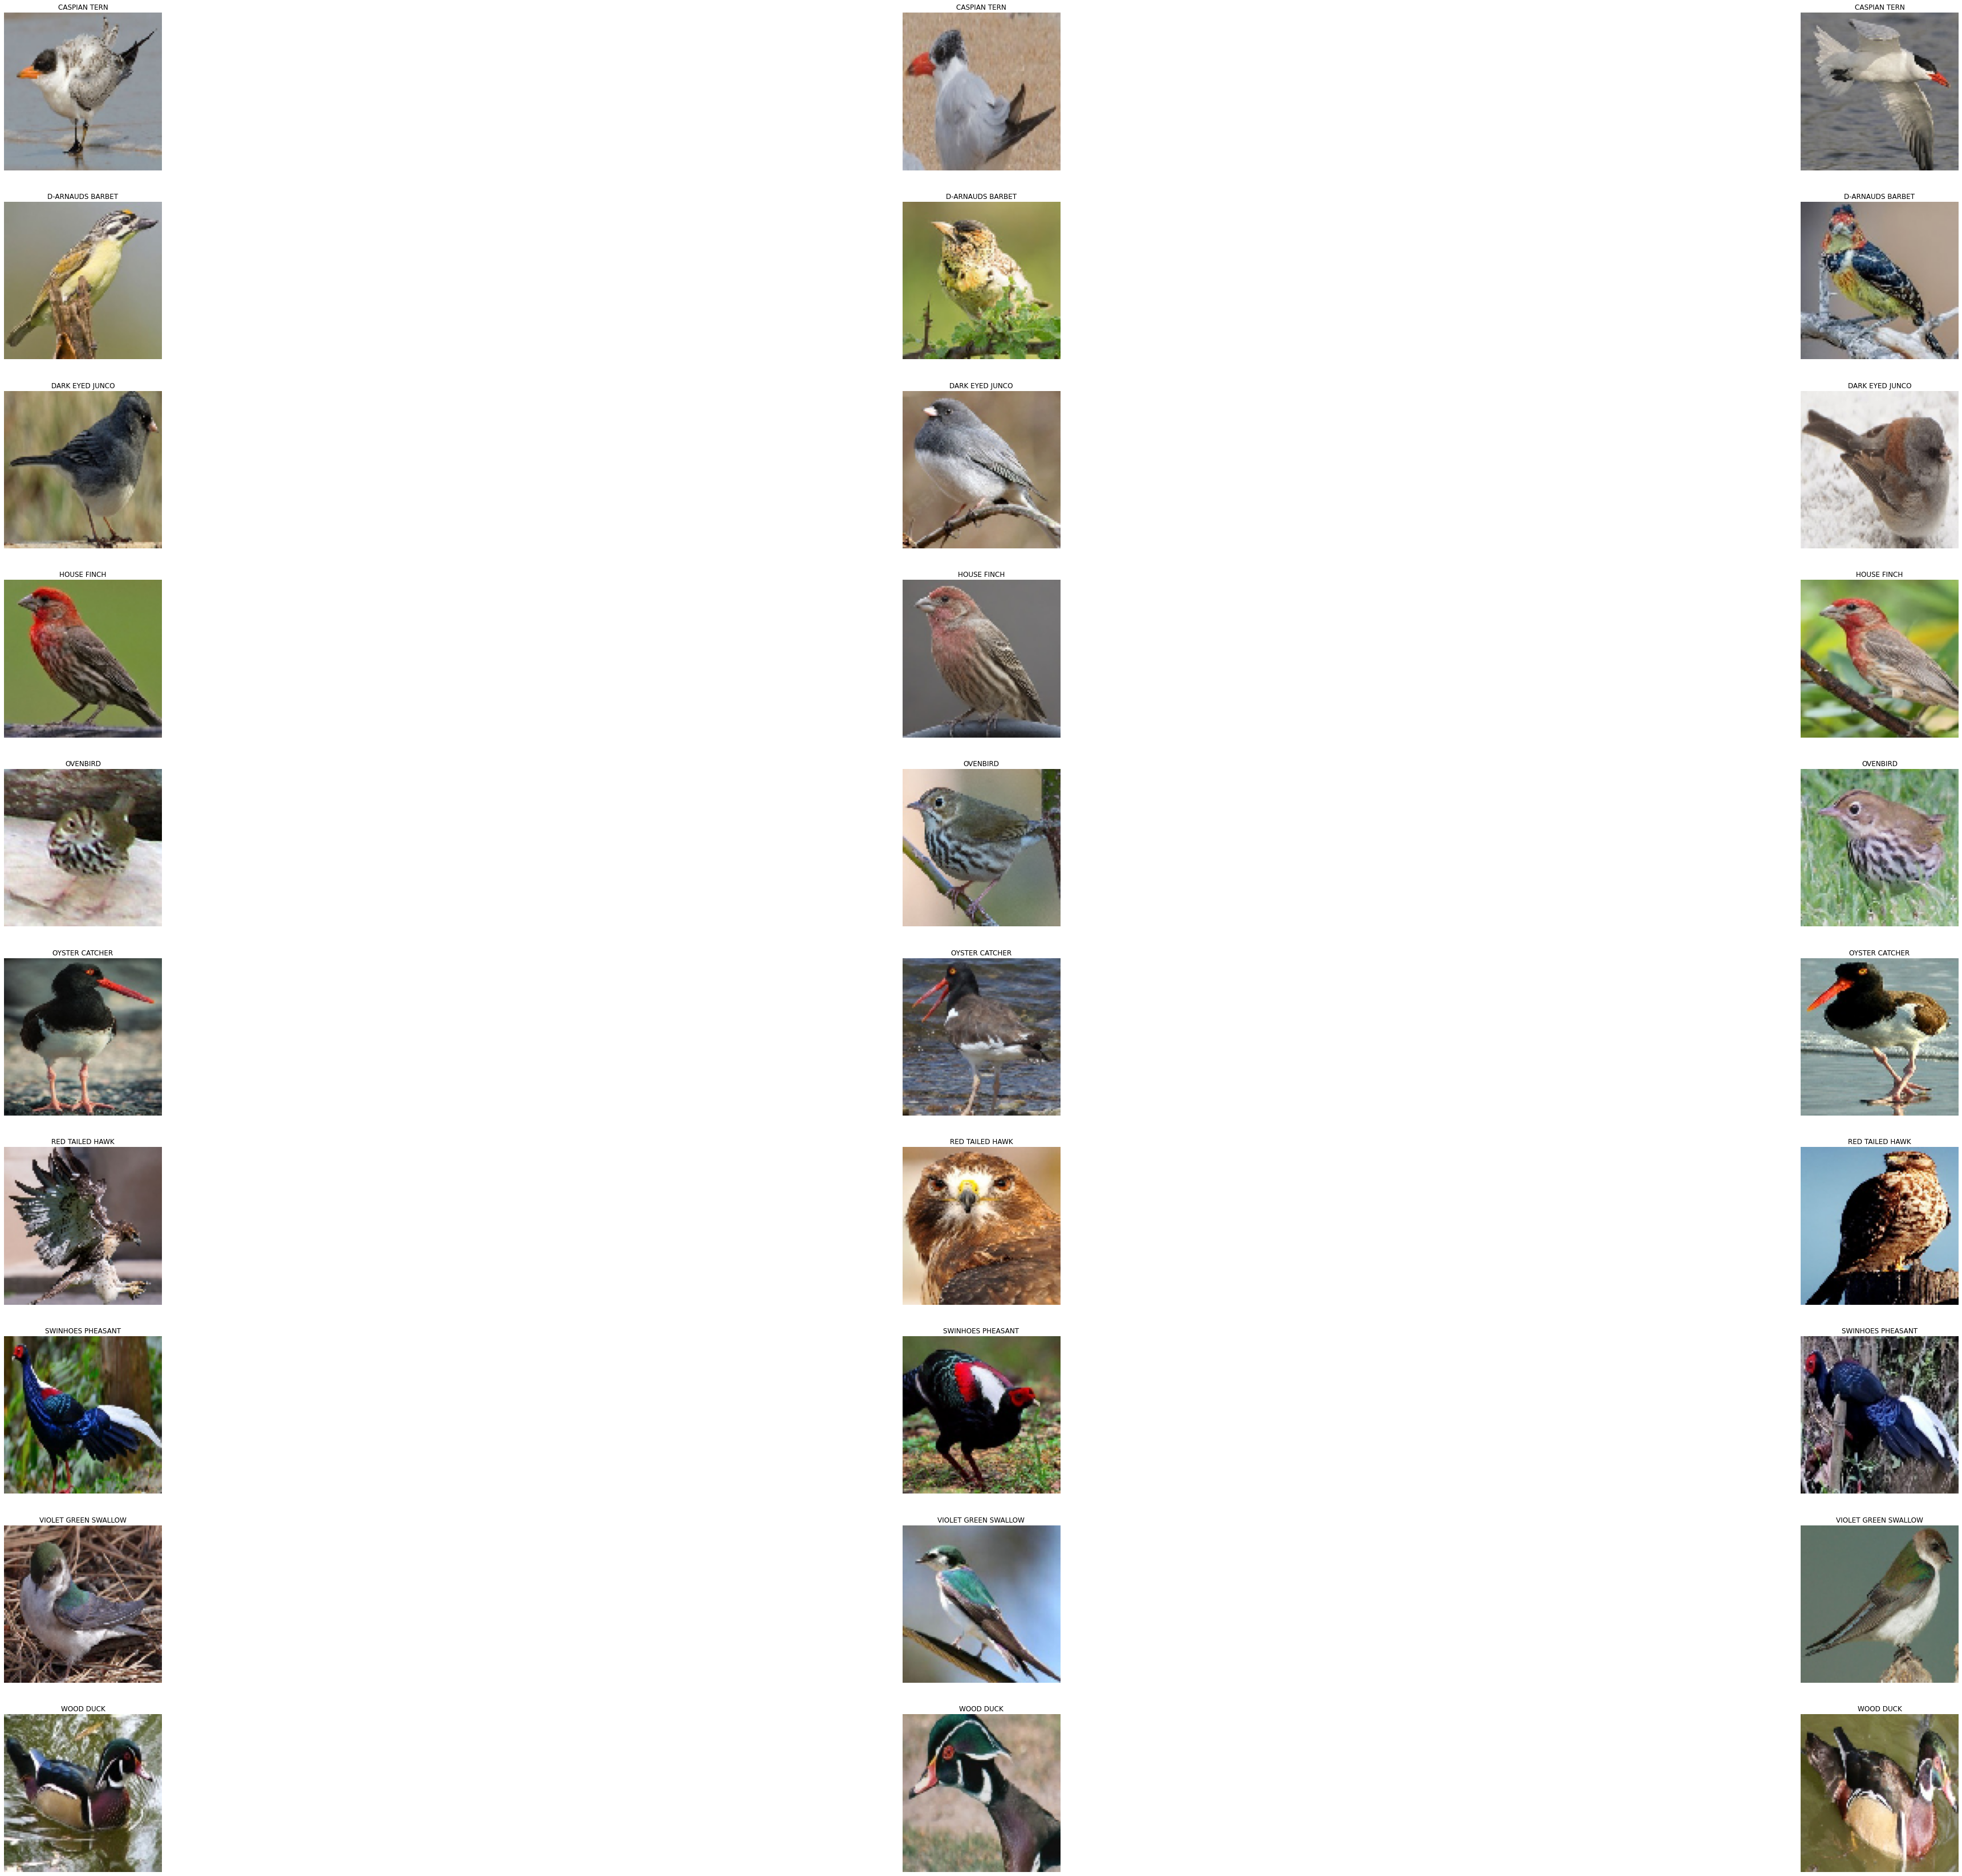

In [88]:
# show random samples of the bird classes
data_dir = '/tmp/Project-main/Data/Use'

# store the bird names in a list
bird_names = [name for name in os.listdir(data_dir)]

# dictionaries for storing the images belonging to each bird class and randomly selected for plotting
bird_dic = {}
select_dic = {}

print('The bird classes are: ')

# for each bird class do
for name in bird_names:
  print(name)

  # get the list of jpgs
  bird_dic[name] = [fn for fn in os.listdir('{}/{}'.format(data_dir, name)) if fn.endswith('jpg')]

  # randomly select 3 images
  select_dic[name] = np.random.choice(bird_dic[name], 3, replace = False)


# plotting 10 x 3 image matrix
fig = plt.figure(figsize = (80,60))
for i in range(30):
    if i < 3:
        fp = '{}/CASPIAN TERN/{}'.format(data_dir, select_dic['CASPIAN TERN'][i])
        label = 'CASPIAN TERN'
    elif i >= 3 and i < 6:
        fp = '{}/D-ARNAUDS BARBET/{}'.format(data_dir, select_dic['D-ARNAUDS BARBET'][i-3])
        label = 'D-ARNAUDS BARBET'
    elif i >= 6 and i < 9:
        fp = '{}/DARK EYED JUNCO/{}'.format(data_dir, select_dic['DARK EYED JUNCO'][i-6])
        label = 'DARK EYED JUNCO'
    elif i >= 9 and i < 12:
        fp = '{}/HOUSE FINCH/{}'.format(data_dir, select_dic['HOUSE FINCH'][i-9])
        label = 'HOUSE FINCH'
    elif i >= 12 and i < 15:
        fp = '{}/OVENBIRD/{}'.format(data_dir, select_dic['OVENBIRD'][i-12])
        label = 'OVENBIRD'
    elif i >= 15 and i < 18:
        fp = '{}/OYSTER CATCHER/{}'.format(data_dir, select_dic['OYSTER CATCHER'][i-15])
        label = 'OYSTER CATCHER'
    elif i >= 18 and i < 21:
        fp = '{}/RED TAILED HAWK/{}'.format(data_dir, select_dic['RED TAILED HAWK'][i-18])
        label = 'RED TAILED HAWK'
    elif i >= 21 and i < 24:
        fp = '{}/SWINHOES PHEASANT/{}'.format(data_dir, select_dic['SWINHOES PHEASANT'][i-21])
        label = 'SWINHOES PHEASANT'
    elif i >= 24 and i < 27:
        fp = '{}/VIOLET GREEN SWALLOW/{}'.format(data_dir, select_dic['VIOLET GREEN SWALLOW'][i-24])
        label = 'VIOLET GREEN SWALLOW'
    else:
        fp = '{}/WOOD DUCK/{}'.format(data_dir, select_dic['WOOD DUCK'][i-27])
        label = 'WOOD DUCK'
    ax = fig.add_subplot(10, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='rgb')
    plt.imshow(fn)
    plt.title(label)
    plt.axis('off')
plt.show()

### Images as Matrix

In [85]:
# make nxm matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

pixel_dic = {}

# run on the bird folders
for name in bird_names:
  pixel_dic[name] = img2np('{}/{}/'.format(data_dir, name), bird_dic[name])

### Average Image per class

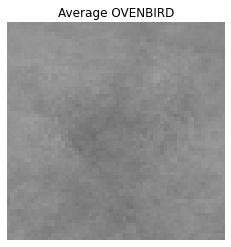

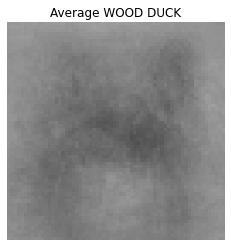

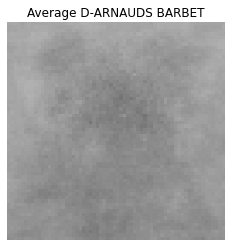

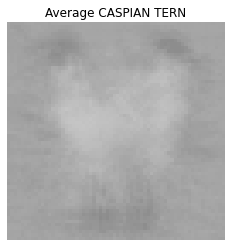

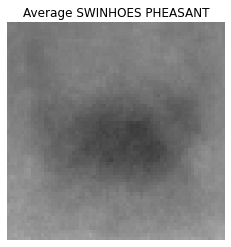

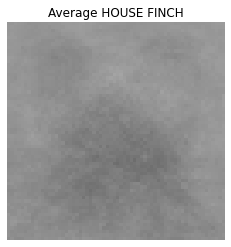

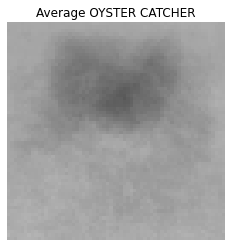

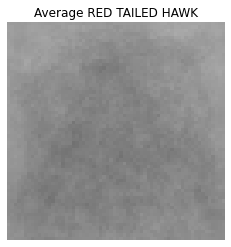

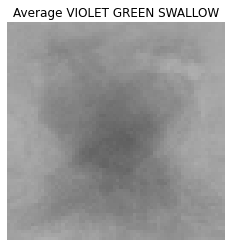

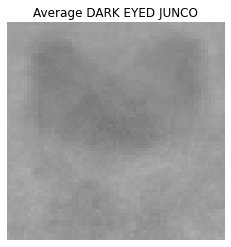

In [89]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

mean_dic = {}

for name in bird_names:
  mean_dic[name] = find_mean_img(pixel_dic[name], name)

###Eigenimages

Uses PCA to visualize the components that describe each class best.

Number of PC:  27


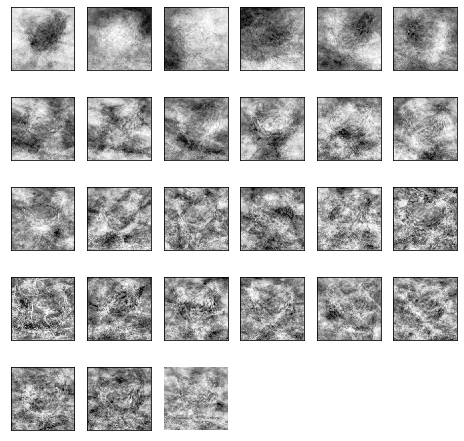

Number of PC:  29


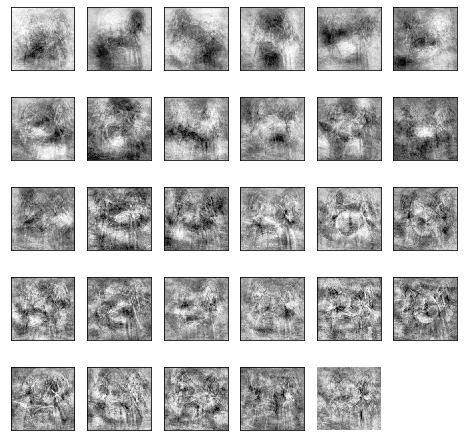

Number of PC:  27


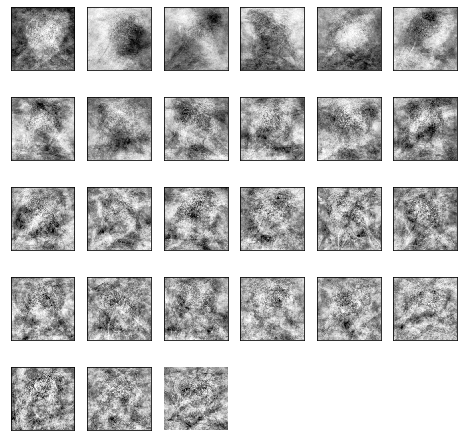

Number of PC:  14


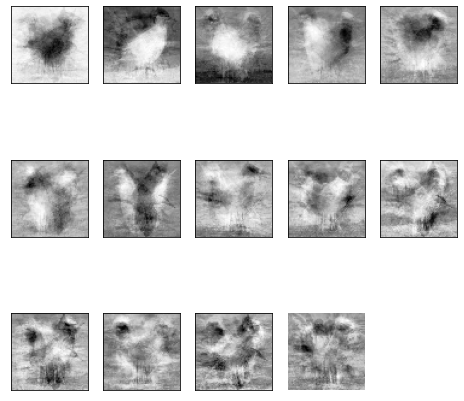

Number of PC:  24


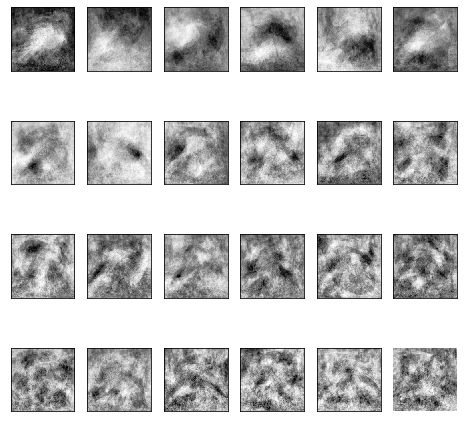

Number of PC:  18


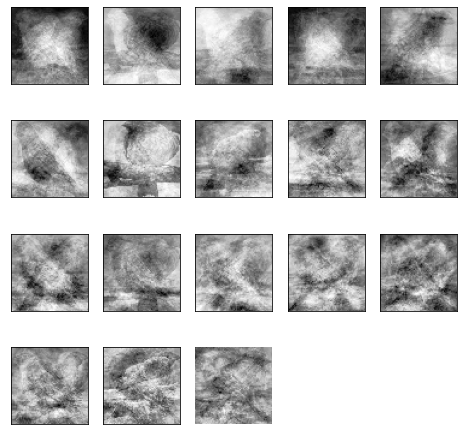

Number of PC:  18


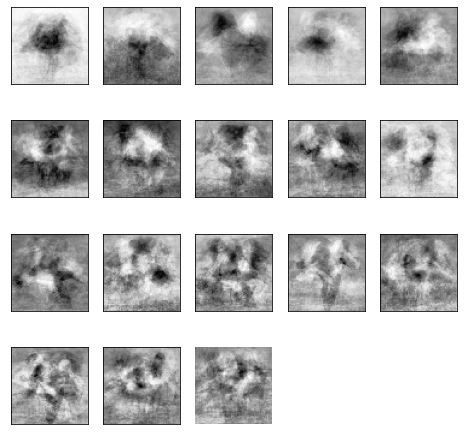

Number of PC:  20


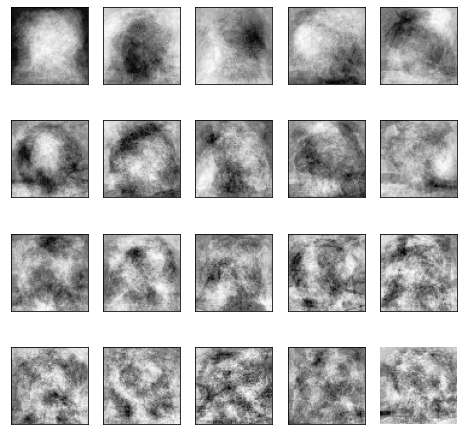

Number of PC:  18


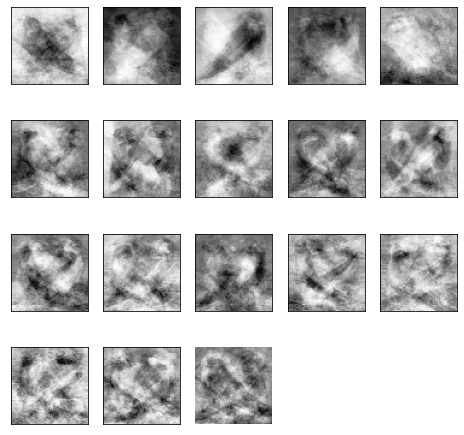

Number of PC:  16


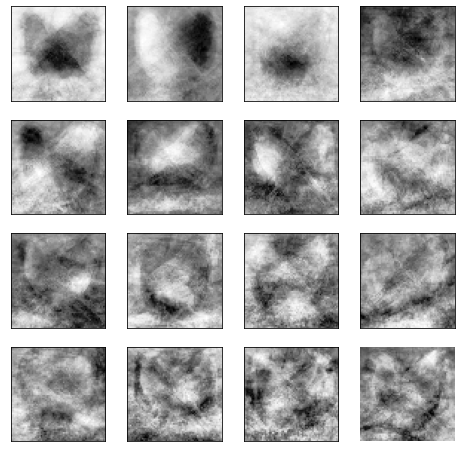

In [82]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
for name in bird_names:
  plot_pca(eigenimages(pixel_dic[name], name))